In [2]:
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from collections import namedtuple
import heapq
import seaborn as sns

from market import SimulationClock
from market import Exchange

In [28]:
def bgt_scheduler( clock, FV, p_flex, lam, order_size_bound, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    quantity = np.random.randint(1,order_size_bound+1)*np.random.choice([-1,1])
    price = FV + np.random.randint(-p_flex,p_flex+1)
    heapq.heappush(event_queue,[clock.time+delta_t, price,quantity,trader,order_type])

def mm_scheduler(a1, a2, a3, b1, b2, b3, c1, c2, c3, d1, d2, d3, clock, lam, ba, bb, lastprice, depth, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    if lastprice >= ba:
        quantity = a1*(lastprice - ba) + b1*depth
        price = c1*lastprice + d1*depth
    elif lastprice < bb:
        quantity = a2*(lastprice - bb) - b2*depth
        price = c2*lastprice + d2*depth
    else:
        quantity = 0
        price = c3*lastprice + d3*depth
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm1_scheduler(clock, e1, f1, ba, bb, trader):
    order_type = 0
    lam = e1
    delta_t = np.random.exponential(lam)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = bb
        quantity = buy_sell_sign*f1
    else:
        price = ba
        quantity = buy_sell_sign*f1
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass



In [ ]:
generations = 10
population = 100
selection = 10
n_params = 2
mutation_rate = 0.1


sim_duration = 30
burn_in = 10

# parameters 
e1 = np.random.uniform(0.5,1,100)
f1 = np.random.uniform(0,20,100)
def mutate(idx):
    if idx == 0:
        return np.random.uniform(0.5,1)
    elif idx == 1:
        return np.random.uniform(0,10)

population = list(zip(e1,f1))

for gen in range(generations): 
# simulate
    events = []
    FVs = []
    clk = SimulationClock()
    exch = Exchange(clk)
    BAs = []
    BBs = []
    t=0

    order_size_bound = 10
    FV = 10
    p_flex = 3
    p_reset = 0.01
    lam_bgt = 0.5
    lam_mm = 0.5

    event_queue = []

    #init
    for trader in range(0,100):
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

    #burn_in
    while clk.time < burn_in:
        # execute next event
        event = heapq.heappop(event_queue)
        event_time, price, quantity, trader, order_type = event
        clk.time = event_time
        exch.post(price, quantity, trader, order_type)
        # reset FV
        if trader < 100:
            if np.random.rand(1) < p_reset:
                FV = price
        # schedule new event
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

        # stats
        events.append([clk.time,event[2],event[1]]) 
        FVs.append(FV)
        ba = exch.get_best_ask()
        bb = exch.get_best_bid()
        if ba == None:
            ba_price = 0
        else:
            ba_price = ba.price
        if bb == None:
            bb_price = 0
        else:
            bb_price = -bb.price
        BAs.append(ba_price)
        BBs.append(bb_price)

    depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]
    
    for trader in range(100,200):
        k = trader - 100
        params = population[k]
        mm1_scheduler(clk, params[0], params[1], BAs[-1], BBs[-1], trader)

    while clk.time < sim_duration:
        # execute next event
        event = heapq.heappop(event_queue)
        event_time, price, quantity, trader, order_type = event
        clk.time = event_time
        exch.post(price, quantity, trader, order_type)
        # reset FV
        if trader < 100:
            if np.random.rand(1) < p_reset:
                FV = price

        # stats
        events.append([clk.time,event[2],event[1]]) 
        FVs.append(FV)
        ba = exch.get_best_ask()
        bb = exch.get_best_bid()
        if ba == None:
            ba_price = 0
        else:
            ba_price = ba.price
        if bb == None:
            bb_price = 0
        else:
            bb_price = -bb.price
        BAs.append(ba_price)
        BBs.append(bb_price)

        depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]

        # schedule new event
        if trader >= 100:
            k = trader - 100
            params = population[k]
            mm1_scheduler(clk, params[0], params[1], BAs[-1], BBs[-1], trader)        
        else:
            bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)
    
    # profit calculation
    trades = np.array(exch.trades)
    profit=[]
    for i in range(100,200):
        profit.append(-sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6]*trades[trades[:,4]==i][:,2]) 
                      +sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]*trades[trades[:,5]==i][:,2])
                      +(sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6])
                      -sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]))*exch.lastprice)

# evolution
    profit = np.array(profit)
    population = np.array(population)
    top_traders = profit.argsort()[-selection:][::-1]
    #print(top_traders)
    top_profit = profit[top_traders]
    top_params = population[top_traders]
    
    print(gen)
    print(top_profit)
    print(top_params)
    
    population = [[a,b] for a in top_params[:,0] for b in top_params[:,1]]
    for i in range(len(population)):
        for j in range(len(population[i])):
            if np.random.rand(1) < mutation_rate:
                population[i][j] = mutate(j)
    #population
    
    


0
[ 38.51853781  38.1702017   17.49275501  14.95775127  14.72964107
  14.24994649  14.          13.51640339  11.5095246   10.72953414]
[[  0.83020713  19.25926891]
 [  0.57364161  19.08510085]
 [  0.52960311  17.49275501]
 [  0.513502    14.95775127]
 [  0.59111861  14.72964107]
 [  0.97753702  14.24994649]
 [  0.5616465   14.81207049]
 [  0.6011306    6.75820169]
 [  0.77075637  11.5095246 ]
 [  0.5021326    5.36476707]]
1


In [59]:
trades = np.array(exch.trades)
#exch.trades

In [60]:
events = np.array(events)

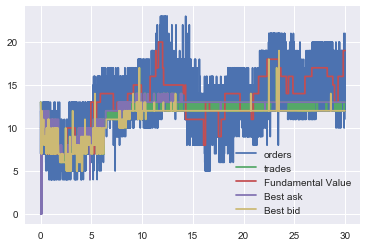

In [61]:
plt.plot(events[:,0],events[:,2], label = 'orders')
plt.plot(trades[:,0],trades[:,2], label = 'trades')
plt.plot(events[:,0],FVs, label = 'Fundamental Value')
plt.plot(events[:,0],BAs, label = 'Best ask')
plt.plot(events[:,0],BBs, label = 'Best bid')
plt.legend()

In [131]:
#list(zip(BAs,BBs))
#np.sort(np.array(exch.bids,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#np.sort(np.array(exch.asks,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#len(events)